## I. Learning algorithm

This solution is almost an exact copy of my [previous project](https://github.com/AlekseySyryh/DRL_ContinuousControl). 

There are two identical, but independent agents in the solution. Each agent is a relatively simple implementation of Deep Deterministic Policy Gradients (DDPG) Actor-Critic algorythm. As the name suggests, the agent consists of two networks - Actor (the network that chooses the action) and Critic (the network decides whether the action was good or not, so it helps to actor  to converge much faster).

Due to the fact that the dimension of feature space is relatively small (24), for the solution we will have enough simple fully connected networks.

Actor network have 24 inputs (for number for dimensions), and Critic have 26 inputs (number of dimensions + number of actions). First hidden layer of both networks have 256 outputs, and second layer have 128 outputs. To have some nonlinearity all hidden layers have ReLU activation function. Actor network have 2 outputs (for number of actions) with tanh activation function (so that the probability of one action does not become too big), and Critic have 1 output - aproximation of Q value for the state-action pair.

The following measures have been taken to improve convergence:

We have two copies of each network. Initially they are the same. In the process, we train locale networks by using target networks. At the same time, the target network itself is changing very slowly (although it tends to local). It helps to prevent instabilities in learning.

We initialize initial weight of networks as described [here](https://arxiv.org/abs/1509.02971)

For balance exploration-exploitation tradeoff we are using some thins:

1. For balance exploration-exploitation tradeoff, I am using epsilon parameter which decreasing from 1 by 0.02% every episode until it reach value of 0.1 - and it is the likelihood that noise will be used in this episode. If you look at the results of the training, we see an interesting picture. At the end of training, several attempts out of 100 are made for the maximum score, but the rest are much worse (for example, half of the attempts have a result no better than 0.2) - the introduction of this attenuation somewhat improves the result. I'm not sure that this is really important because the same model, but it seems that without a noise it simply does not know how to make mistakes, but in any case, it converges somewhat faster.

1. For the exploration noise process we I temporally correlated noise in order to explore well in physical environments that have momentum. I used an Ornstein-Uhlenbeck process as described [here](https://arxiv.org/abs/1509.02971), but I am using theta = 0.1. Due to the stochastic nature of the learning process, I cannot be absolutely sure that this value is better, but it seemed to me that this is so. 

The Adam optimizer are usual first-option optimizer, as usual works quite good in our case. Optimal learinig rate for out networks are something around 0.0001. 

The remaining parameters are left as is. They just work.

## II. Plot of Rewards

In [1]:
import pickle as pkl
with open('scores.pkl','rb') as f:
    stat=pkl.load(file=f)

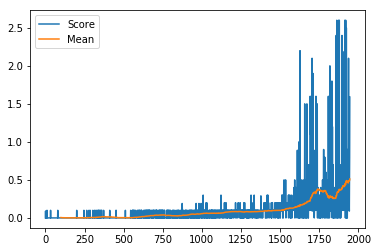

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.DataFrame({"Score":stat})
data["Mean"]=data.rolling(100).mean()
data.plot()
plt.show()

Environment solved in 1946 episodes

## III. Solution example

In [3]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name='c:/Tennis_Windows_x86_64/Tennis.exe');
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
from network import Actor
actor1 = Actor(24,2,1)
actor2 = Actor(24,2,1)

In [5]:
import torch
actor1.load_state_dict(torch.load('actor1.final.pth'))
actor2.load_state_dict(torch.load('actor2.final.pth'))

In [6]:
for x in range(5):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)
    score = np.zeros(2)
    while True:
        action=[actor1(torch.tensor(state[0],dtype=torch.float32)).detach().numpy(),actor2(torch.tensor(state[1],dtype=torch.float32)).detach().numpy()]
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        dones = env_info.local_done                        # see if episode finished
        score += env_info.rewards                         # update the score (for each agent)        
        state = next_state # roll over states to next time step
        if np.any(dones):
            print(score.max())
            break

2.600000038743019
2.7000000402331352
2.600000038743019
2.7000000402331352
2.7000000402331352


In [7]:
env.close()

An interesting effect. In training, in 50% of cases, the agent managed to hit the ball no more than two times. I thought it was some kind of learning problem, but here (without noise) there is no such problem. So the algorithm looks good enough.

## IV. Ideas for future work

Collaboration looks good, and agents can play long enough now. Now it's time to start Competition part.

What if reward of one agent will be also a penalty of another (may be with some discount)? I do not think that such an approach would have worked when learning from scratch, but for an agent who was trained on this task, this might work (some kind of transfer learning).

As usual, I will probably check out some other algorithms, but there is not much point in this - the result is already as close as possible to the ideal one. I never managed to see how the agent is mistaken.